# Contextualized Topic Modeling (CTM) on a Small Scientific Corpus

In [ ]:
%%capture
# !pip install contextualized-topic-models==1.8.1
!pip install sentence-transformers
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

## Import libaries and dependencies

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/contextualized-topic-models-master

/content/drive/MyDrive/contextualized-topic-models-master


In [ ]:
from contextualized_topic_models.models.ctm import CombinedTM, ZeroShotTM
from contextualized_topic_models.utils.data_preparation import bert_embeddings_from_file, TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing
from contextualized_topic_models.datasets.dataset import CTMDataset
from contextualized_topic_models.evaluation.measures import CoherenceNPMI, InvertedRBO
import gensim
from gensim.corpora.dictionary import Dictionary
import os
import numpy as np
import pickle
import pandas as pd
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Data Preparation

### Read our data files and store the documents as lists of strings

In [ ]:
# MODEL DATA CATALOG ABSTRACT DATA:
df = pd.read_csv('abstracts.csv')
df["title_text"] = df["Title"] + ' ' + df["Text"]
wp = WhiteSpacePreprocessing(df.title_text)
text_training_preprocessed, text_training_not_preprocessed, vocab_list = wp.preprocess()

#### NOTE: Make sure that the lenghts of the two lists of documents are the same and the index of a not preprocessed document corresponds to the index of the same preprocessed document.

In [ ]:
print(len(text_training_preprocessed) == len(text_training_not_preprocessed))

True


## Split into Train/Test Sets

In [ ]:
# contextual documents are used in neural topic models whereas other models, such as LDA, only take BoW

training_bow_documents = text_training_preprocessed[0:38]
training_contextual_document = text_training_not_preprocessed[0:38]

testing_bow_documents = text_training_preprocessed[38:]
testing_contextual_documents = text_training_not_preprocessed[38:]

In [ ]:
#set the number of topics for all models here:
n_topic = 9

# Neural Topic Modeling

In [ ]:
# colab example https://colab.research.google.com/drive/12zBvL0v0qZHbpSGXLLjHfQ0w6OZOVHaB#scrollTo=KhLt6VA3wvCB
# github https://github.com/MilaNLProc/contextualized-topic-models#preprocessing
# prodLDA https://arxiv.org/pdf/1703.01488.pdf
# neural prodLDA + specter embedding rep article https://arxiv.org/pdf/2004.03974v1.pdf

## **CTM Overview**
#### Combine pre-trained representations (from SPECTER)and neural topic model (neural prodLDA) = Contextualized Topic Model (CTM). Most topic models still use Bag of Words (BoW) document representations as model input, rather than contextualized representations (https://colab.research.google.com/drive/1VkOBoXC298_-QG6PllBJ-IimHsajLlgR#scrollTo=-P9GmgEZPyIv) below. BoW representations do not account for syntactic and semantic relationships among the words in a document.


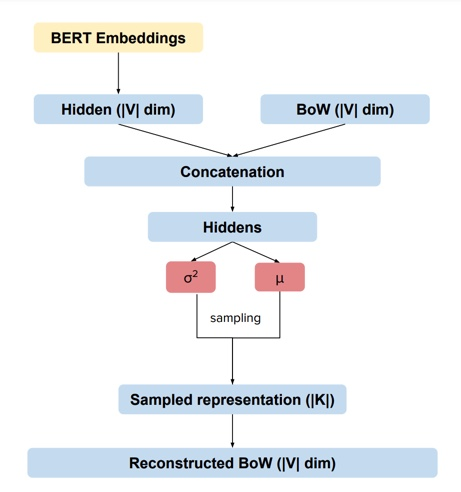

In [ ]:
#uncomment to use regular BERT
# tp = TopicModelDataPreparation("bert-base-nli-mean-tokens")

# Using SPECTER from ALLENAI
tp = TopicModelDataPreparation("allenai-specter")

In [ ]:
training_dataset = tp.create_training_set(training_contextual_document, training_bow_documents)

##### Let's check the vocabulary

In [ ]:
tp.vocab[:10]

['ability',
 'absence',
 'acceleration',
 'accepted',
 'acceptor',
 'acceptors',
 'access',
 'accommodates',
 'account',
 'accounted']

## Load & Use CTM

In [ ]:
ctm = CombinedTM(input_size=len(tp.vocab), bert_input_size=768, num_epochs=200, num_topics=n_topic, model_type='prodLDA',
                 hidden_sizes=(128, 128), activation='softplus', dropout=0.2,
                 learn_priors=True, batch_size=10, lr=2e-2, momentum=0.99,
                 solver='adam', reduce_on_plateau=True, num_data_loader_workers=4)
ctm.fit(training_dataset) 

Epoch: [200/200]	 Seen Samples: [7600/7600]	Train Loss: 897.2611919202303	Time: 0:00:00.296835: : 200it [00:58,  3.44it/s]


### Get topics list

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
ctm.get_topics(5)

defaultdict(list,
            {0: ['climate', 'water', 'vegetation', 'region', 'models'],
             1: ['equations', 'flow', 'dimensional', 'aquifer', 'one'],
             2: ['model', 'change', 'climate', 'coasts', 'coupling'],
             3: ['coasts', 'sediment', 'hydrodynamics', 'system', 'reef'],
             4: ['output', 'programs', 'computer', 'version', 'fortran'],
             5: ['derived', 'motion', 'deep', 'motions', 'included'],
             6: ['psd', 'urban', 'used', 'runoff', 'stormwater'],
             7: ['solver', 'vertical', 'fluid', 'package', 'simulates'],
             8: ['hydraulic', 'heat', 'solute', 'conductivity', 'simulating']})

### Look at a word cloud

In [ ]:
%%capture
pip install matplotlib==3.1.3

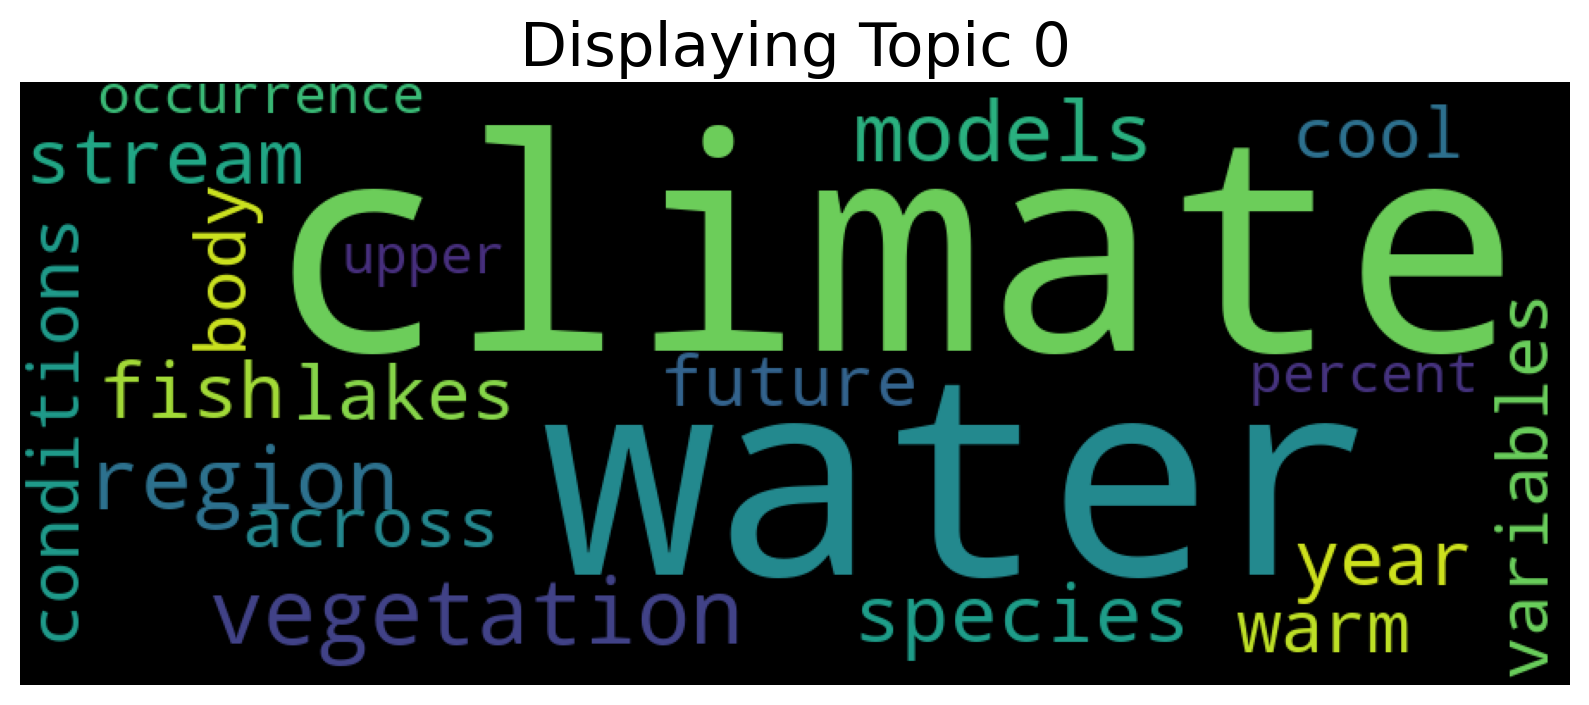

In [ ]:
# Word Cloud for first topic:
ctm.get_wordcloud(topic_id=0, n_words=20)

### Validation

In [ ]:
testing_dataset = tp.create_test_set(testing_contextual_documents, testing_bow_documents) # create dataset for the testset
# print(testing_dataset[0])

In [ ]:
predictions = ctm.get_doc_topic_distribution(testing_dataset)

Sampling: [20/20]: : 20it [00:05,  3.45it/s]

2
9


In [ ]:
pt = ctm.get_predicted_topics(testing_dataset, n_samples=2)
print(pt)

Sampling: [2/2]: : 2it [00:00,  3.44it/s]

2
9
[6, 8]


## Evaluate CTM - Coherence Score

In [ ]:
#Combine topic score
texts = list(map(lambda x : x.split(), training_bow_documents))
npmi = CoherenceNPMI(texts=texts, topics=ctm.get_topic_lists(10))
npmi.score()

['climate', 'water', 'vegetation', 'region', 'models', 'species', 'fish', 'stream', 'year', 'lakes']
['equations', 'flow', 'dimensional', 'aquifer', 'one', 'feq', 'transport', 'head', 'oteq', 'full']
['model', 'change', 'climate', 'coasts', 'coupling', 'reef', 'predict', 'coastal', 'coral', 'species']
['coasts', 'sediment', 'hydrodynamics', 'system', 'reef', 'module', 'coral', 'coastal', 'flooding', 'factors']
['output', 'programs', 'computer', 'version', 'fortran', 'graphical', 'program', 'user', 'files', 'includes']
['derived', 'motion', 'deep', 'motions', 'included', 'next', 'decreases', 'eruptive', 'anelastic', 'currently']
['psd', 'urban', 'used', 'runoff', 'stormwater', 'could', 'nurp', 'permanence', 'size', 'median']
['solver', 'vertical', 'fluid', 'package', 'simulates', 'modflow', 'lpf', 'upw', 'nwt', 'groundwater']
['hydraulic', 'heat', 'solute', 'conductivity', 'simulating', 'new', 'package', 'permeable', 'simulated', 'saturated']


-0.07331647244408877